In [1]:
# Packages

import gzip
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
from zipfile import ZipFile
from collections import OrderedDict
import matplotlib.pyplot as plt
import gzip
import re
import ast
import os
import json
import pickle
import plotly.figure_factory as ff
import plotly.express as px
import math
from more_itertools import locate

### Here we checking how many instances per sample where, multiple variations are present within repeat sequence.

In [36]:
# Builidng the code for the file structure.

Write_directory = '../../STR_Mutational_Dynamics/Designing/'
Read_directory = '../Denovo_analysis_599Trios/'

def seq_analysis(infile):
    
    out = open(f'{Write_directory}multiple_variations.tsv','a')
    
    with gzip.open(f'{Read_directory}{infile}', 'rt') as offspring:
        offspring.readline()
        
        multiple_type_variations = 0
        total_denovo_regions = 0
        for denovo_region in offspring:
            
            denovo_region = denovo_region.strip().split('\t')
            if denovo_region[-1] !='-': continue
            total_denovo_regions += 1
            Denovo_CIGAR = denovo_region[-5]
            
            # Considering only repeat sequence.
            Denovo_Repeat_CIGAR = Denovo_CIGAR.split('|')           
            
            split = re.findall('(\d+|[A-Za-z]+)', Denovo_Repeat_CIGAR[1])
            chars =  split[::2]
            num_bases = split[1::2]
            
            # checking if CIGAR contains more than one variation.
            if chars.count('I') > 1 or chars.count('D') > 1 or chars.count('X') > 1:
                multiple_type_variations += 1
            elif ('I' in chars and 'D' in chars) or('I' in chars and 'X' in chars) or ('X' in chars and 'D' in chars) :
                multiple_type_variations += 1
    
        print(infile,multiple_type_variations,total_denovo_regions, file =out, sep = '\t')

# testing purpose
# seq_analysis('TRIO0007_denovo.tsv.gz')

In [37]:
# iterating the files of the directory.

Read_directory = '../../STR_Mutational_Dynamics/Denovo_analysis_599Trios/'

for file in tqdm(os.listdir(Read_directory)):
    
    if file.endswith('.tsv.gz'):
        seq_analysis(file)

100%|██████████████████████████████████████████████████████████████████████| 602/602 [01:13<00:00,  8.15it/s]


In [53]:
# reading file

df = pd.read_csv('../../../STR_Mutational_Dynamics/Designing/multiple_variations.tsv', header=None, sep='\t')
df.columns = ['file_id', 'Multiple_variants_locations', 'Total_Denovo_regions']


In [54]:
df.head()

,file_id,Multiple_variants_locations,Total_Denovo_regions
0,TRIO0001_denovo.tsv.gz,44,10005
1,TRIO0002_denovo.tsv.gz,43,10283
2,TRIO0003_denovo.tsv.gz,39,10361
3,TRIO0004_denovo.tsv.gz,30,9189
4,TRIO0005_denovo.tsv.gz,34,9047


In [61]:
# Graph for seeing the distribution of the num of multiple variants locations.

fig = px.histogram(df, x='Multiple_variants_locations')
fig.update_xaxes(nticks=35)
fig.update_yaxes(nticks=30)


fig.show()

In [63]:
# here we try to observe the num of multiple locations per samples with the reference of total number of denovo regions count.

fig = px.scatter(df, y='Multiple_variants_locations', x='Total_Denovo_regions')
fig.update_xaxes(nticks=25)
fig.update_yaxes(nticks=25)
fig.show()

In [ ]:
# catching point, we see the range of 25 to 65 range of multiple denovo regions count overall all the denovo files.

In [68]:
# here we get the added or deleted partial sequence from the flanks and which are the part of it.

def Repeat_flanking_seq_Insertion(CIGAR_bases, CIGAR_seq):

    R_flank = []
    L_flank = []
    Repeat = []

    CIGAR_bases = CIGAR_bases.split(',')
    CIGAR_seq = CIGAR_seq.split('|')

    # Getting the inserted and deleted sequences.
    for i in range(0, CIGAR_seq[0].count('I')):
        L_flank.append(CIGAR_bases[i])
    
    for i in range(CIGAR_seq[0].count('I'), int(CIGAR_seq[0].count('I')) + int(CIGAR_seq[1].count('I'))):
        Repeat.append(CIGAR_bases[i])

    for i in range(CIGAR_seq[0].count('I') + CIGAR_seq[1].count('I'), len(CIGAR_bases)):
        R_flank.append(CIGAR_bases[i])

    return L_flank, Repeat, R_flank

In [69]:
# here we get the added or deleted partial sequence from the flanks and which are the part of it.

def Repeat_flanking_seq_Deletion(CIGAR_bases, CIGAR_seq):

    R_flank = []
    L_flank = []
    Repeat = []

    CIGAR_bases = CIGAR_bases.split(',')
    CIGAR_seq = CIGAR_seq.split('|')

    # Getting the inserted and deleted sequences.
    for i in range(0, CIGAR_seq[0].count('D')):
        L_flank.append(CIGAR_bases[i])
    
    for i in range(CIGAR_seq[0].count('D'), int(CIGAR_seq[0].count('D')) + int(CIGAR_seq[1].count('D'))):
        Repeat.append(CIGAR_bases[i])

    for i in range(CIGAR_seq[0].count('D') + CIGAR_seq[1].count('D'), len(CIGAR_bases)):
        R_flank.append(CIGAR_bases[i])

    return L_flank, Repeat, R_flank

In [70]:
# here we get the added or deleted partial sequence from the flanks and which are the part of it.

def Repeat_flanking_seq_SNP(CIGAR_bases, CIGAR_seq):

    R_flank = []
    L_flank = []
    Repeat = []

    CIGAR_bases = CIGAR_bases.split(',')
    CIGAR_seq = CIGAR_seq.split('|')

    # Getting the inserted and deleted sequences.
    for i in range(0, CIGAR_seq[0].count('X')):
        L_flank.append(CIGAR_bases[i])
    
    for i in range(CIGAR_seq[0].count('X'), int(CIGAR_seq[0].count('X')) + int(CIGAR_seq[1].count('X'))):
        Repeat.append(CIGAR_bases[i])

    for i in range(CIGAR_seq[0].count('X') + CIGAR_seq[1].count('X'), len(CIGAR_bases)):
        R_flank.append(CIGAR_bases[i])

    return L_flank, Repeat, R_flank

In [84]:
# Builidng the code for the file structure.

Write_directory = '../../STR_Mutational_Dynamics/Designing/'
Read_directory = '../Denovo_analysis_599Trios/'

def seq_analysis(infile):
    c = 0
    out_file_id = infile.split('_')[0]
    out = open(f'{Write_directory}multiple_variations_region_info.tsv', 'a')
    
    with gzip.open(f'{Read_directory}{infile}', 'rt') as offspring:
        offspring.readline()
        
        for denovo_region in offspring:
            
            denovo_region = denovo_region.strip().split('\t')
            if denovo_region[-1] != '-': continue
            rep_len = denovo_region[-9]
            Denovo_len = denovo_region[-6]
            Denovo_CIGAR = denovo_region[-5]
            motif_len = len(denovo_region[3])
            
            
            
            # Considering only repeat sequence.
            Denovo_Repeat_CIGAR = Denovo_CIGAR.split('|')           
            
            # initializing the variables.
            unit_pos = 0
            
            
            # index of 'I'.
            split = re.findall('(\d+|[A-Za-z]+)', Denovo_Repeat_CIGAR[1])
            chars =  split[::2]
            num_bases = split[1::2]
            
            
            
            # getting the flanking and with in repeat added or deleted seq.
            per_region_CIGAR_I_info = Repeat_flanking_seq_Insertion(denovo_region[-3], Denovo_CIGAR)
            per_region_CIGAR_D_info = Repeat_flanking_seq_Deletion(denovo_region[-2], Denovo_CIGAR)
            per_region_CIGAR_X_info = Repeat_flanking_seq_SNP(denovo_region[-1], Denovo_CIGAR)
            
            
            
            # getting the position of unit where mutation has encountered and the sequence bases which has changed.
            if ('I' in chars and 'D' in chars) or('I' in chars and 'X' in chars) or ('X' in chars and 'D' in chars):
                print(*denovo_region[0:6], Denovo_len,denovo_region[-9], motif_len, f'{per_region_CIGAR_I_info[0]}|{per_region_CIGAR_I_info[1]}|{per_region_CIGAR_I_info[-1]}',f'{per_region_CIGAR_D_info[0]}|{per_region_CIGAR_D_info[1]}|{per_region_CIGAR_D_info[-1]}',f'{per_region_CIGAR_X_info[0]}|{per_region_CIGAR_X_info[1]}|{per_region_CIGAR_X_info[-1]}', Denovo_CIGAR, denovo_region[-4])#, file =out, sep='\t')
            elif chars.count('I') > 1 or chars.count('D') > 1 or chars.count('X') > 1 :
                print(*denovo_region[0:6], Denovo_len,denovo_region[-9], motif_len, f'{per_region_CIGAR_I_info[0]}|{per_region_CIGAR_I_info[1]}|{per_region_CIGAR_I_info[-1]}',f'{per_region_CIGAR_D_info[0]}|{per_region_CIGAR_D_info[1]}|{per_region_CIGAR_D_info[-1]}',f'{per_region_CIGAR_X_info[0]}|{per_region_CIGAR_X_info[1]}|{per_region_CIGAR_X_info[-1]}', Denovo_CIGAR, denovo_region[-4])#, file =out, sep='\t')
                
#     out.close()
 
 # testing purpose
seq_analysis('TRIO0007_denovo.tsv.gz')

chr1 7139232 7139248 TATATT AAATAT 7139232 10 16 6 []|[]|['-'] ['A']|['T', 'TTATA']|['A'] []|[]|['-'] D1|D1M10D5|D1 ATATTTATAT
chr1 16616293 16616314 TA AT 16616292 37 49 2 []|[]|['-'] ['TG']|['TC', 'TATATATATC']|[] []|[]|['-'] D2|M18D2M18D10M1| (TA)18T
chr1 206923790 206923802 AGTGTG ACACTC 206923790 12 12 6 []|['GG']|[] []|['T', 'T']|[] []|[]|['-'] M1|M2D1M1D1M6I2M1| CAGGGAGTGTGGG
chr2 121232107 121232158 TTTTG AAAAC 121232106 49 41 5 ['CA']|['ATGAA', 'GGA']|[] []|[]|['-'] []|[]|['-'] I2M2|I5M2I3M39| CACTATGAATTGGA(TTGTT)7TTGT
chr2 165767869 165767892 T A 165767869 25 23 1 []|['G', 'A']|[] []|[]|['-'] []|[]|['-'] M1|M23I1I1|M1 C(T)23GA(T)1
chr2 191714447 191714494 AT AT 191714447 52 44 2 []|['A', 'T', 'A', 'T', 'A', 'C', 'A', 'C']|[] []|[]|['-'] []|[]|['-'] M1|M44I1I1I1I1I1I1I1I1| A(AT)24(AC)2
chr3 76272833 76272854 TATATAT AATATAT 76272830 20 21 7 []|['T']|[] ['A']|['T', 'T']|[] []|[]|['-'] D1M3|M4D1M1D1M8I1M6| (ATATATA)2TTTATATAT
chr5 25753289 25753311 TTTTTG AAAAAC 25753289 15 22 

In [83]:
# iterating the files of the directory.

Read_directory = '../../STR_Mutational_Dynamics/Denovo_analysis_599Trios/'

for file in tqdm(os.listdir(Read_directory)):
    
    if file.endswith('.tsv.gz'):
        seq_analysis(file)

100%|██████████████████████████████████████████████████████████████████████| 602/602 [01:47<00:00,  5.58it/s]


In [26]:
# putting pops in dictionary.

samples_info_dict = {}

with open('../../../STR_Mutational_Dynamics/1KG_Trio_samples.tsv') as samples_info :
    samples_info.readline()
    
    for info in tqdm(samples_info):
        
        info = info.strip().split('\t')
        samples_info_dict[info[0]] = [info[-2], info[-1]]


603it [00:00, 608411.19it/s]


In [80]:
# analysing the counts of the multiple variations present within the repeat and partial motif replication.

df_deletions = pd.read_csv('../../../STR_Mutational_Dynamics/Seq_patterns/Deletions_info.tsv',header=None, sep='\t')

In [84]:
# adding the pop info to the multiple variant dataframe.

super_pop_list = []
sub_pop_list = []

for ind in df_deletions.index:
    
    trio_id = df_deletions[0][ind].split('_')[0]
    
    if trio_id in samples_info_dict:
        
        pop_info = samples_info_dict[trio_id]
        super_pop_list.append(pop_info[-1])
        sub_pop_list.append(pop_info[0])
        
temp_df = pd.DataFrame({'Sub_pop':sub_pop_list, 'Super_pop':super_pop_list})
df_deletions1 = pd.concat([df_deletions, temp_df], axis=1)
df_deletions1.columns = ['Trio_id', 'Single_deletion_counts', 'Total_denovo_regions', 'Sub_pop', 'Super_pop']

In [92]:
# Graph for seeing the distribution of the num of multiple variants locations.

fig = px.box(df_deletions1[df_deletions1['Total_denovo_regions'] != 0], y='Total_denovo_regions', color='Super_pop')
fig.update_yaxes(nticks=16)
fig.show()

In [86]:
df_deletions1['Single_deletion_counts'].groupby(df_deletions1['Super_pop']).median()

Super_pop
AFR    521.0
AMR    579.0
EAS    618.0
EUR    520.5
SAS    526.0
Name: Single_deletion_counts, dtype: float64

In [87]:
# here we try to observe the num of multiple locations per samples with the reference of total number of denovo regions count.

fig = px.scatter(df_deletions1, y='Single_deletion_counts', x='Total_denovo_regions')#, color='Super_pop')
fig.update_xaxes(nticks=25)
fig.update_yaxes(nticks=25)
fig.show()

In [177]:
# Here we are trying to ask based on Repeat len wise !


Deletion_regions = []

Read_directory = '../Seq_patterns/Partial_deletion/'

def Deletion(infile):
    
    with gzip.open(f'{Read_directory}{infile}', 'rt') as offspring:
        offspring.readline()
        
        for denovo_region in offspring:
            
            denovo_region = denovo_region.strip().split('\t')
            chrm = denovo_region[0]
            start = denovo_region[1]
            end = denovo_region[2]
            
            region = f'{chrm}:{start}-{end}'
            
            Deletion_regions.append(region)


In [178]:
# iterating the files of the directory.

Read_directory = '../../STR_Mutational_Dynamics/Seq_patterns/Partial_deletion/'

for file in tqdm(os.listdir(Read_directory)):
    
    if file.endswith('.tsv.gz'):
        Deletion(file)

100%|████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 1059.77it/s]


In [179]:
# checking the number of common regions with in the insertion regions.

# counting the regions which are being similar among the samples.
Common_deletion_counts = Counter([x[1] for x in Counter(Deletion_regions).most_common()])

sizes = []
label = []

# limiting the number of regions to be atleast in 10 samples.
for info in Common_deletion_counts:
    
    if int(info) >= 10:
        sizes.append(Common_deletion_counts[info])
        label.append(info)

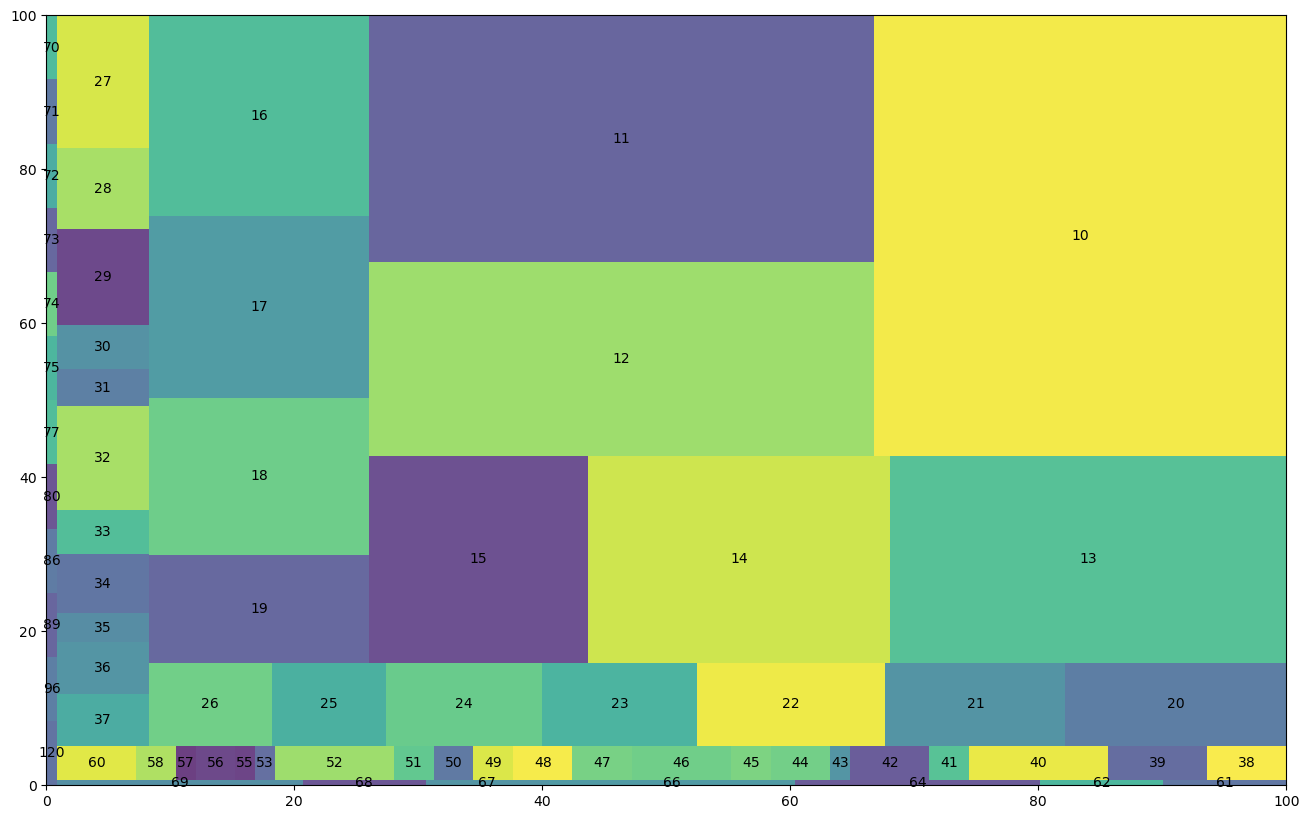

In [180]:
# commonality among the denovo regions


import matplotlib.pyplot as plt
import squarify 
squarify.plot(sizes=sizes, label=label, alpha=0.8)
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.show()

In [253]:
# picking the highest RC.


Rc = []
Am = []
trio_file_id = []

Read_directory = '../Seq_patterns/Partial_insertion/'

def highest_rc(infile):
    
    with gzip.open(f'{Read_directory}{infile}', 'rt') as offspring:
        offspring.readline()
        
        file_id = infile.split('_')[0]
        for denovo_region in offspring:
            
            denovo_region = denovo_region.strip().split('\t')
            
            Rmotif = denovo_region[4]
            if Rmotif == 'AGAT' :
                
                print(denovo_region[3:5], denovo_region[6:8], denovo_region[9:11], denovo_region[11], denovo_region[12], denovo_region[-1])


# highest_rc('TRIO0004_insertion.tsv.gz')

In [254]:
# iterating the files of the directory.

Read_directory = '../../STR_Mutational_Dynamics/Seq_patterns/Partial_insertion/'

for file in tqdm(os.listdir(Read_directory)):
    
    if file.endswith('.tsv.gz'):
        highest_rc(file)

 28%|███████████████████▎                                                | 170/599 [00:00<00:00, 1574.28it/s]

['TATC', 'AGAT'] ['19', '17'] ["[]|['TA']|[]", '4'] TA M1|M12I2M5| Middle
['TATC', 'AGAT'] ['53', '50'] ['[]|CAT|[]', '1'] CAT M1|I3M50| Start
['TATC', 'AGAT'] ['34', '33'] ["[]|C|['T']", '1'] C,T M1|I1M33|M5I1 Start
['ATCT', 'AGAT'] ['61', '18'] ["[]|['TATATATATCTATATATATAGATATATATATATATATATCTAA']|[]", '4'] TATATATATCTATATATATAGATATATATATATATATATCTAA M1|M15I43M3| Middle
['ATCT', 'AGAT'] ['24', '23'] ['[]|T|[]', '7'] T M1|M23I1| End
['ATCT', 'AGAT'] ['44', '43'] ["[]|['T']|[]", '2'] T M1|M7I1M36| Middle
['CTAT', 'AGAT'] ['22', '20'] ["[]|['TA']|[]", '5'] TA M1|M17I2M3| Middle
['TCTA', 'AGAT'] ['31', '29'] ["[]|['TA']|[]", '7'] TA M1|M26I2M3| Middle
['ATCT', 'AGAT'] ['54', '53'] ["[]|['A']|[]", '9'] A M1|M33I1M20| Middle
['ATAG', 'AGAT'] ['47', '46'] ['[]|T|[]', '12'] T M1|M46I1| End
['TATC', 'AGAT'] ['53', '47'] ['[]|TCTATC|[]', '1'] TCTATC M1|I6M47| Start
['TCTA', 'AGAT'] ['29', '28'] ["[]|['T']|[]", '4'] T M1|M13I1M15| Middle
['AGAT', 'AGAT'] ['43', '40'] ["[]|['GAT']|[]", '6'] GAT M

100%|████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 1783.29it/s]

['CTAT', 'AGAT'] ['14', '12'] ["[]|['GG']|[]", '3'] GG M1|M10I2M2| Middle
['TCTA', 'AGAT'] ['23', '13'] ["[]|['TATCTATCTA']|[]", '3'] TATCTATCTA M1|M10I10M3| Middle
['TATC', 'AGAT'] ['77', '71'] ["[]|['TCTATC']|[]", '10'] TCTATC M1|M36I6M35|M1 Middle
['GATA', 'AGAT'] ['72', '65'] ["[]|['GATAGAT']|[]", '9'] GATAGAT M1|M35I7M30| Middle
['AGAT', 'AGAT'] ['41', '40'] ["[]|['A']|[]", '5'] A M1|M16I1M24| Middle
['GATA', 'AGAT'] ['45', '40'] ['[]|AGATA|[]', '1'] AGATA M1|I5M40| Start
['ATCT', 'AGAT'] ['51', '50'] ['[]|A|[]', '1'] A M1|I1M50| Start
['ATCT', 'AGAT'] ['17', '16'] ['[]|T|[]', '5'] T M1|M16I1| End
['GATA', 'AGAT'] ['40', '39'] ['[]|A|[]', '11'] A M1|M39I1| End
['TAGA', 'AGAT'] ['15', '14'] ["[]|['T']|[]", '1'] T M1|M1I1M13| Middle
['AGAT', 'AGAT'] ['45', '44'] ['[]|A|[]', '12'] A M1|M44I1| End
['TCTA', 'AGAT'] ['59', '58'] ["[]|['T']|[]", '2'] T M1|M6I1M52| Middle
['ATCT', 'AGAT'] ['46', '45'] ['[]|T|[]', '1'] T M1|I1M45| Start
['TATC', 'AGAT'] ['21', '19'] ["[]|['TC']|['TCTATC']"

In [235]:
# checking the highest Rc

highest_Rc = Counter(Rc)

Rc_type = highest_Rc.keys()
Rc_values = highest_Rc.values()

Rc_counts_df = pd.DataFrame({'Rc' : Rc_type, 'Rc_counts' : Rc_values})

In [244]:
Counter(trio_file_id)

Counter({'TRIO0002': 1,
         'TRIO0003': 1,
         'TRIO0007': 1,
         'TRIO0008': 1,
         'TRIO0012': 1,
         'TRIO0016': 1,
         'TRIO0021': 1,
         'TRIO0024': 1,
         'TRIO0028': 1,
         'TRIO0029': 2,
         'TRIO0033': 1,
         'TRIO0035': 2,
         'TRIO0036': 3,
         'TRIO0041': 1,
         'TRIO0042': 1,
         'TRIO0044': 2,
         'TRIO0045': 1,
         'TRIO0046': 1,
         'TRIO0058': 1,
         'TRIO0059': 1,
         'TRIO0060': 2,
         'TRIO0064': 3,
         'TRIO0066': 1,
         'TRIO0070': 1,
         'TRIO0075': 1,
         'TRIO0076': 2,
         'TRIO0078': 1,
         'TRIO0092': 1,
         'TRIO0093': 1,
         'TRIO0097': 1,
         'TRIO0099': 1,
         'TRIO0117': 1,
         'TRIO0120': 2,
         'TRIO0123': 1,
         'TRIO0127': 1,
         'TRIO0128': 3,
         'TRIO0131': 3,
         'TRIO0132': 1,
         'TRIO0133': 1,
         'TRIO0141': 1,
         'TRIO0143': 2,
         'TRIO01